# Solar Cycle Progression

Analysing solar cycle data from the NOAA Space Weather Prediction Center.

The aim of this analysis is to use measurements of the mean monthly sunspot number (SSN) which has been accuretly recorded since 1755 to view historic trends, plot a smoothed SSN time series, and finally predict the progression of the next solar maxima.

Project data based on:
https://www.swpc.noaa.gov/products/solar-cycle-progression

Machine learning methods: https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [1]:
import urllib, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 20

# https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
from scipy.signal import savgol_filter

In [2]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

c:\Users\levet\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jsonURL = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
with urllib.request.urlopen(jsonURL) as url:
    dataJSON = json.load(url)
data = pd.DataFrame.from_dict(dataJSON)
data.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1,1749-02,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
2,1749-03,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
3,1749-04,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
4,1749-05,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [4]:
# Query data from yr 2000 onwards.
milDt = data[(data['time-tag']>="2012-01") & (data['time-tag']<='2023-11')]

In [5]:
savgol_window, polynomial = 51, 11
savgol = savgol_filter(milDt['ssn'], savgol_window, polynomial)

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

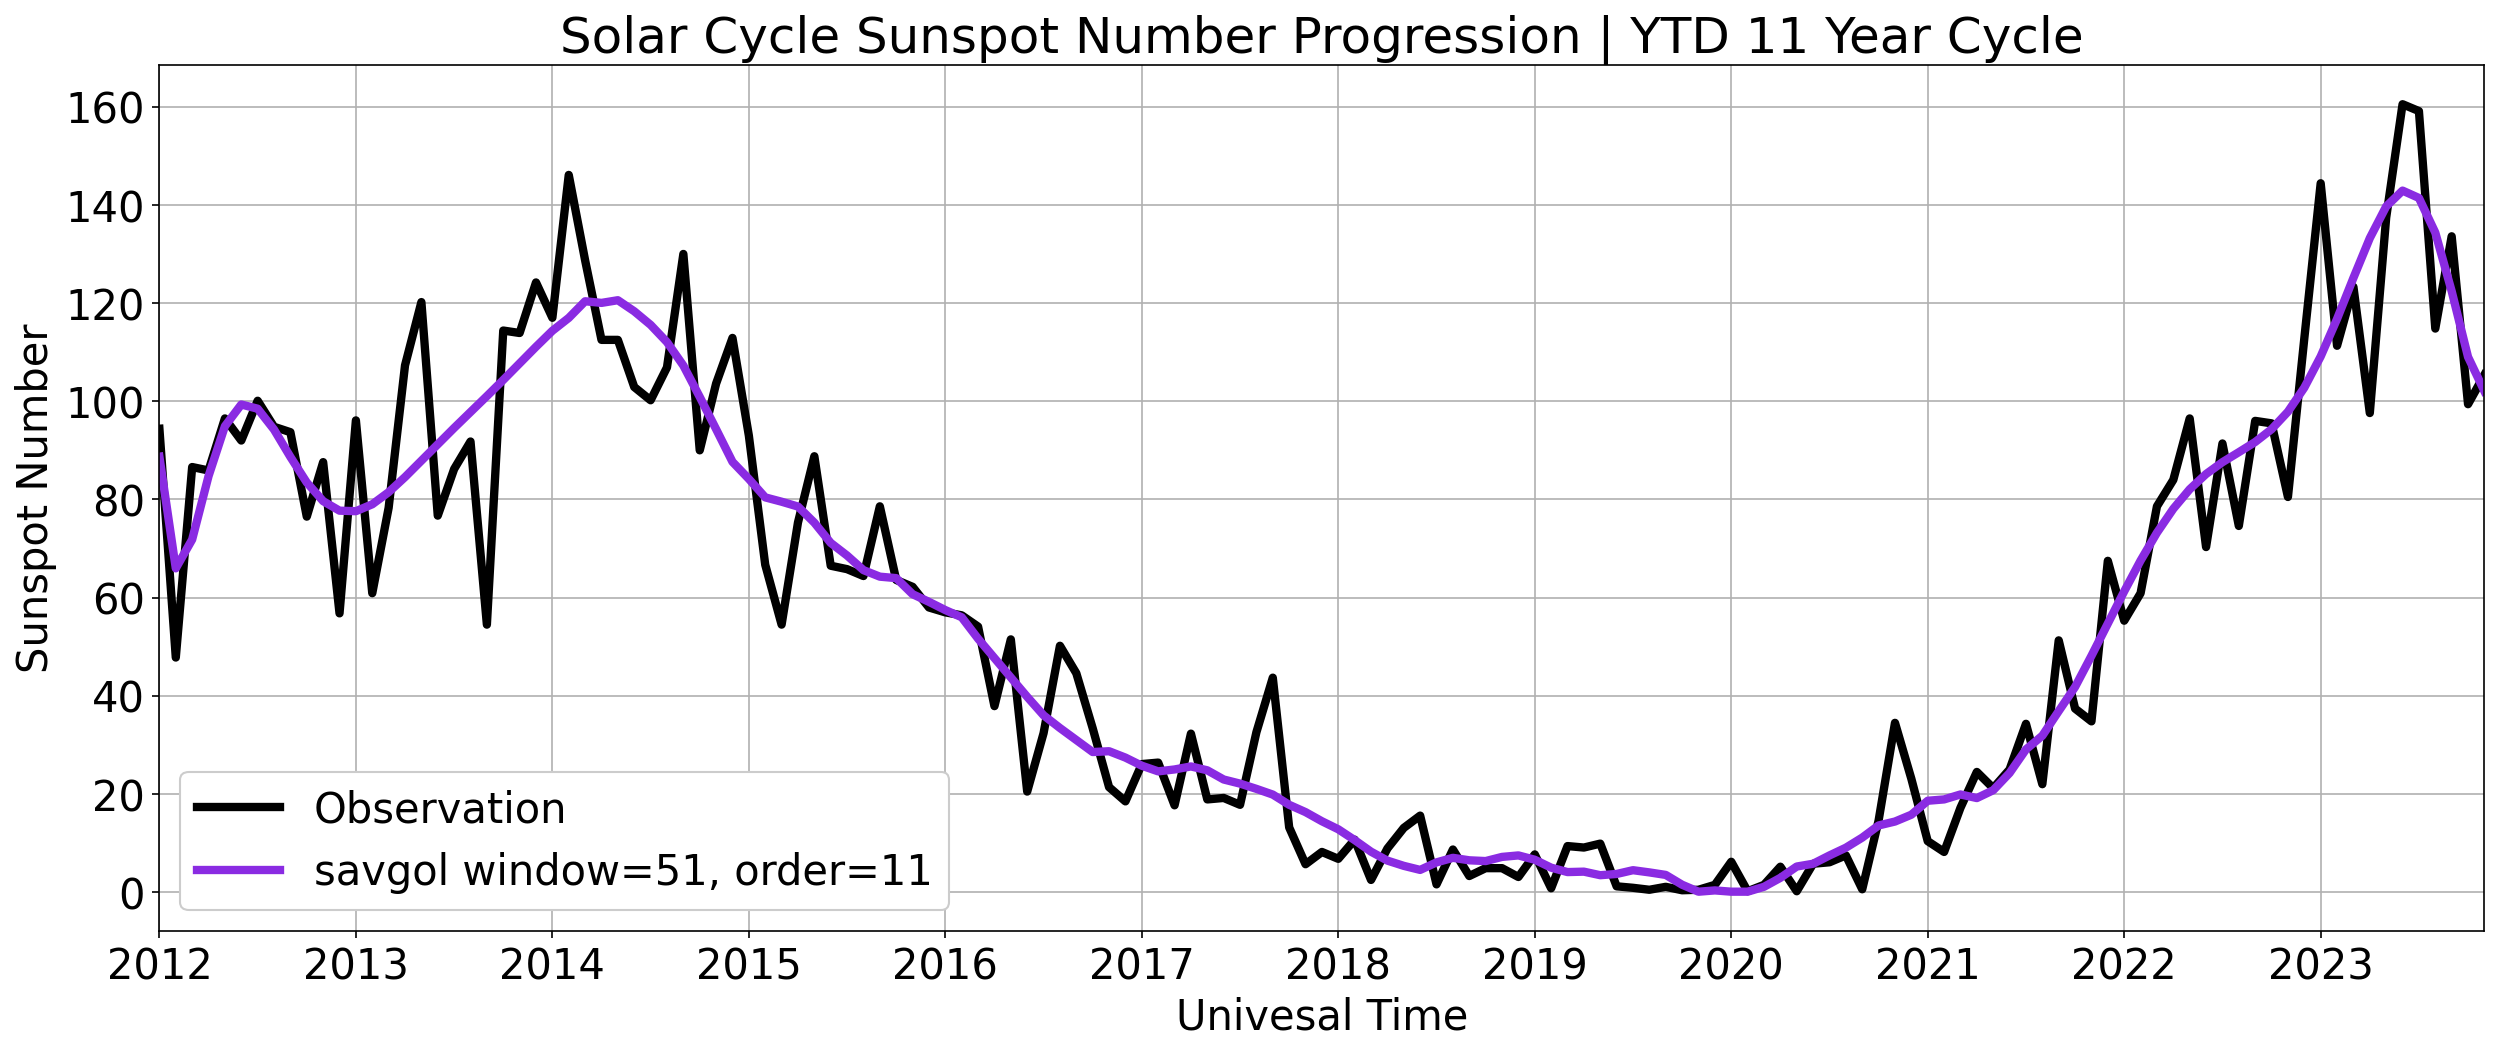

In [6]:
# Plot properties
x_width, y_width = 20, 7.5


# Create plot
fig, ax = plt.subplots(1,1, figsize=(x_width, y_width), dpi=150)

# Add to plot
ax.plot(milDt['time-tag'], milDt['ssn'], '-', color='k', label='Observation')
ax.plot(milDt['time-tag'], savgol, color='blueviolet', label=f'savgol window={savgol_window}, order={polynomial}')
plt.legend(loc='best', framealpha=1)

# Set x-ticks to show every year once
plt.xticks(milDt['time-tag'][::12])
xlabels = [str(i)[:4] for i in milDt['time-tag'][::12]]
ax.set_xticklabels(xlabels, rotation=0)

# Axis labels
plt.xlim(milDt['time-tag'].min(), milDt['time-tag'].max())
plt.title("Solar Cycle Sunspot Number Progression | YTD 11 Year Cycle")
plt.ylabel("Sunspot Number")
plt.xlabel("Univesal Time")
plt.grid()

## Preparing the data

In [7]:
dt = data.rename(columns={'time-tag': 'date'})

dt['date'] = pd.to_datetime(dt['date'], format='%Y-%m')

dt = dt.set_index('date')

# Fill potential gaps with Null
dt = dt.asfreq('MS')

dt = dt.sort_index()
dt.head()


,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
date,,,,,,
1749-01-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-02-01,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
1749-03-01,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-04-01,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
1749-05-01,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [8]:
# Split data into train & test
steps = 132
data_train = dt[:-steps]
data_test  = dt[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 1749-01-01 00:00:00 --- 2012-11-01 00:00:00  (n=3167)
Test dates  : 2012-12-01 00:00:00 --- 2023-11-01 00:00:00  (n=132)


## Recursive autoregressive forecasting

In [13]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(
            random_state=123, 
            ),
    lags = 36
)

forecaster.fit(y=data_train['ssn'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
Transformer for y: None 
Transformer for exog: None 
Window size: 36 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1749-01-01 00:00:00'), Timestamp('2012-11-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 202

In [14]:
# Predictions
steps = 250
predictions = forecaster.predict(steps=steps)
predictions.tail(5)

2033-05-01     7.210
2033-06-01     9.116
2033-07-01    11.855
2033-08-01    17.331
2033-09-01    17.215
Freq: MS, Name: pred, dtype: float64

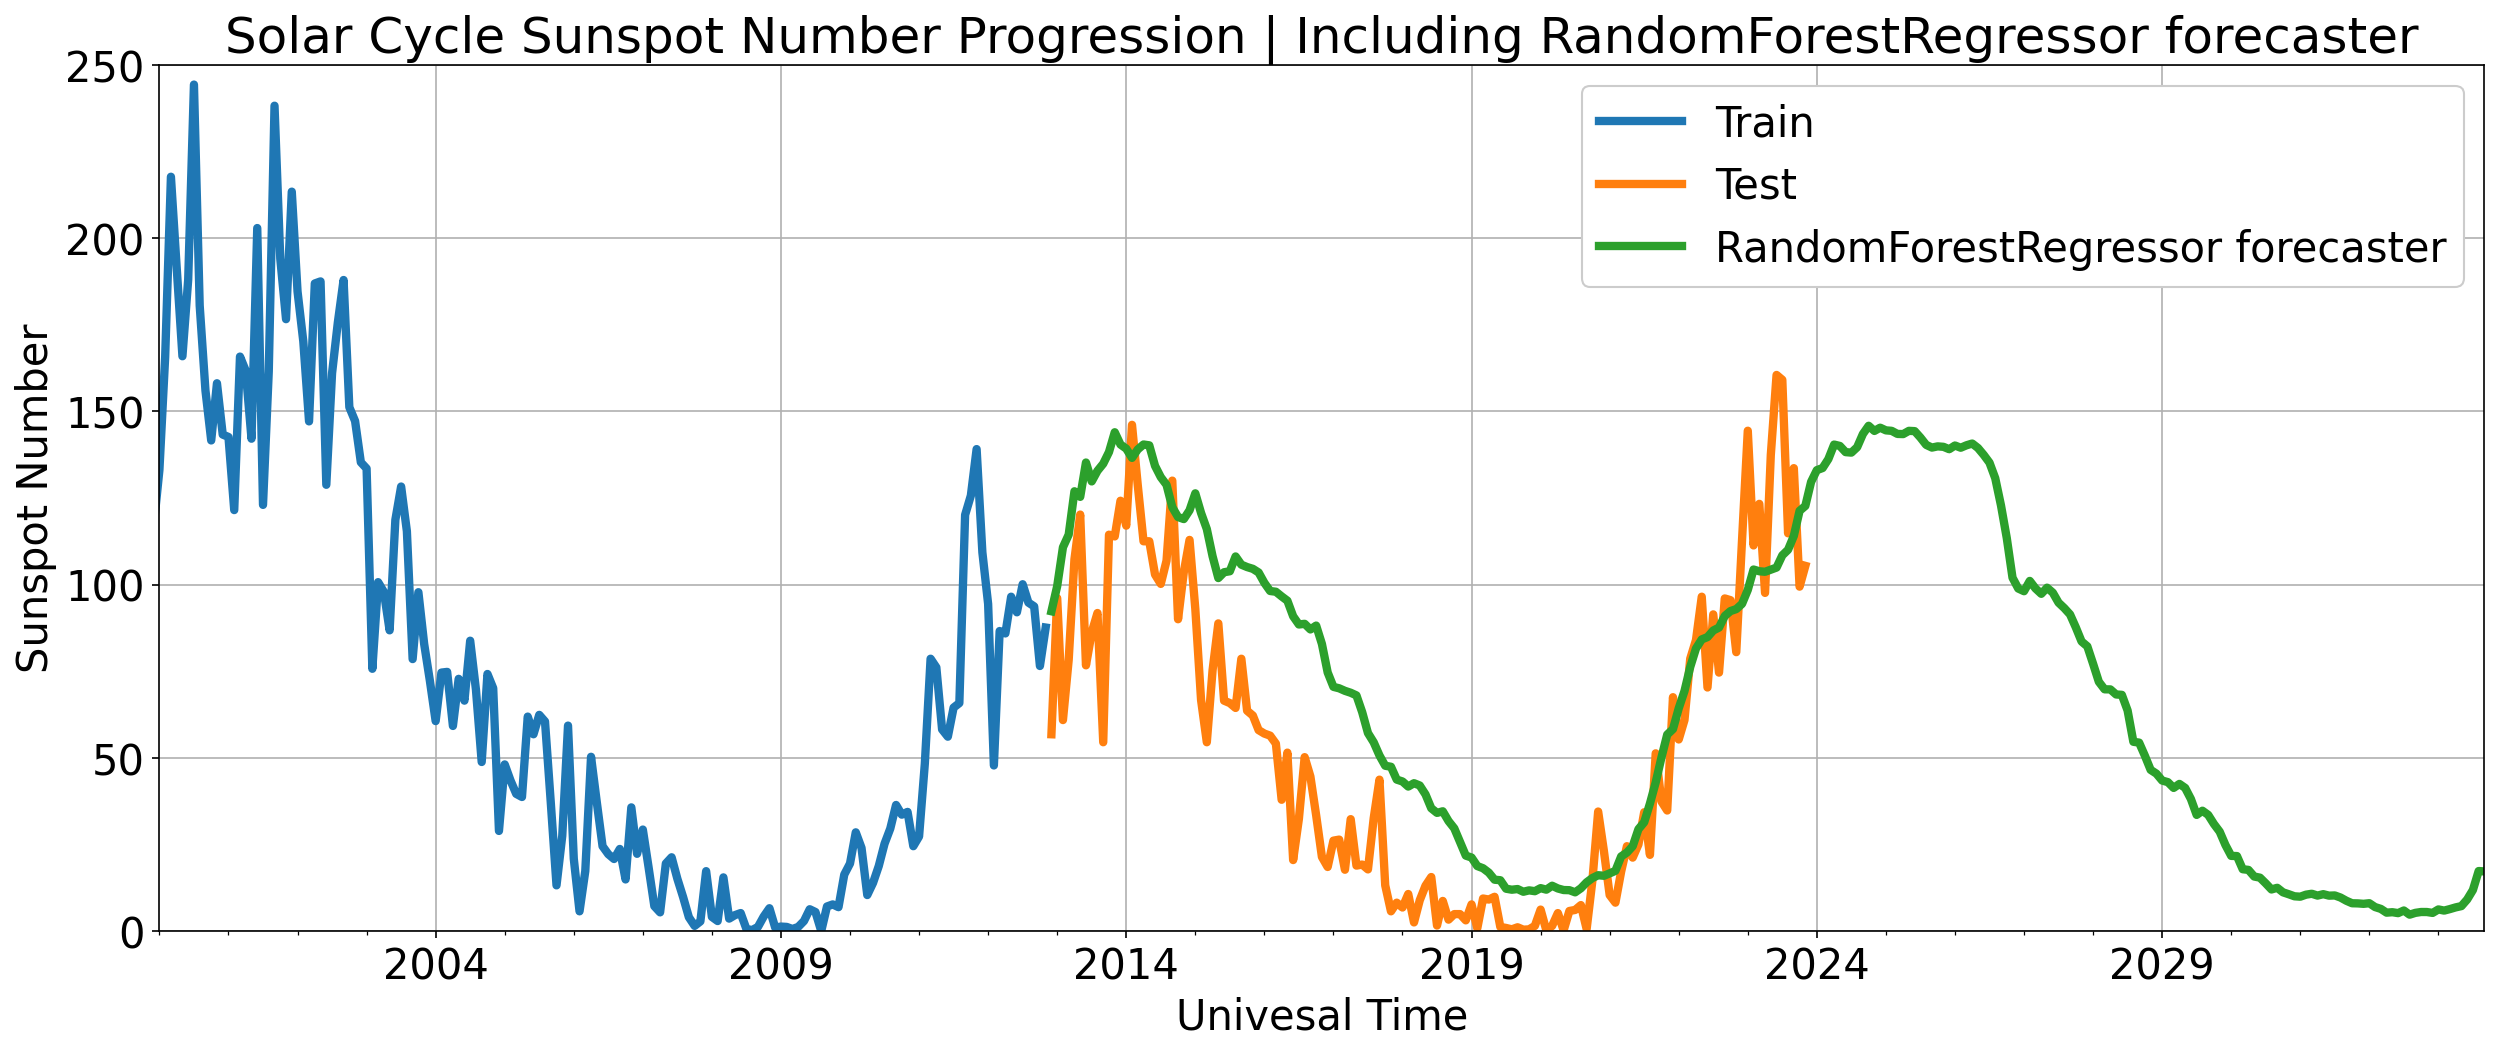

In [15]:
fig, ax = plt.subplots(figsize=(20, 7.5), dpi=150)

data_train['ssn'].plot(ax=ax, label='Train')
data_test['ssn'].plot(ax=ax, label='Test')

# dt['ssn'].plot(ax=ax, label='Data')

# pred = predictions[(predictions.index>=data_test.index.max())]
predictions.plot(ax=ax, label='RandomForestRegressor forecaster')

# Plot labels
plt.legend(loc='best', framealpha=1)
plt.title("Solar Cycle Sunspot Number Progression | Including RandomForestRegressor forecaster")
plt.xlim('2000', predictions.index.max())
plt.ylim(0, 250)
plt.ylabel("Sunspot Number")
plt.xlabel("Univesal Time")
plt.grid()